In [36]:
from mgc.dscr import oneSample
import pandas as pd
import numpy as np
import seaborn as sns

In [37]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')
p_R = pd.read_csv('P.csv')
stat_R = pd.read_csv('stat.csv')

In [38]:
iter = 100
x = np.zeros((300,2),dtype = float)
diffStat = np.zeros(100, dtype=float)
diffP = np.zeros(100, dtype=float)
oneSamp = oneSample()

for i in range(0,iter):
    indx1 = 'V' + str(2*i+1)
    indx2 = 'V' + str(2*i+2)
    
    yIndx = 'V' + str(i+1)
    
    x[:,0] = X[indx1]
    x[:,1] = X[indx2]
    y = Y[yIndx]
    
    stat, p = oneSamp.test(x,y) 
    
    diffStat[i] = stat_R[yIndx] - stat
    diffP[i] = p_R[yIndx] - p

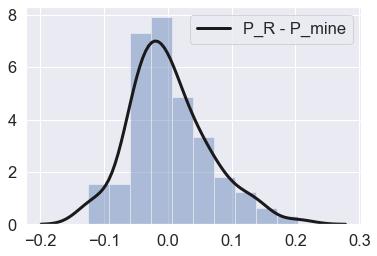

In [47]:
sns.set(font_scale=1.5)
sns.distplot(diffP, hist = True, kde_kws={"color": "k", "lw": 3, "label": "P_R - P_mine"})

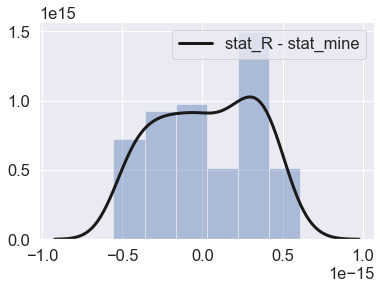

In [48]:
sns.distplot(diffStat, hist = True, kde_kws={"color": "k", "lw": 3, "label": "stat_R - stat_mine"})

In [23]:
indx1

'V-1'

In [49]:
diffStat

array([-2.77555756e-16,  2.22044605e-16,  6.10622664e-16, -5.55111512e-17,
        3.33066907e-16,  1.11022302e-16, -1.11022302e-16, -5.55111512e-17,
        3.88578059e-16, -3.33066907e-16,  2.22044605e-16,  2.22044605e-16,
       -3.33066907e-16,  5.55111512e-16, -1.11022302e-16,  1.11022302e-16,
        5.55111512e-17, -4.44089210e-16, -2.22044605e-16,  1.11022302e-16,
        4.44089210e-16,  2.22044605e-16, -4.44089210e-16,  4.44089210e-16,
        2.77555756e-16,  3.88578059e-16, -3.33066907e-16,  5.55111512e-17,
        3.88578059e-16,  2.22044605e-16,  4.44089210e-16, -2.22044605e-16,
        0.00000000e+00,  3.33066907e-16,  2.22044605e-16, -4.99600361e-16,
        2.22044605e-16, -2.22044605e-16, -1.66533454e-16, -5.55111512e-16,
        4.99600361e-16,  2.22044605e-16, -4.44089210e-16,  1.66533454e-16,
       -5.55111512e-17,  3.88578059e-16, -3.33066907e-16,  1.66533454e-16,
       -5.55111512e-17, -4.44089210e-16, -2.22044605e-16, -4.99600361e-16,
       -3.33066907e-16,  